Demonstrates comparing results between BasiCO and libRoadRunner. 

Credit for Frank Bergmann for contributing to development of the simulator API and providing a BasiCO implementation. 

Requires copasi-basico[ssr], libroadrunner, and matplotlib.

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from roadrunner import RoadRunner
from typing import Dict, List, Union

import libssr
from libssr.SSRSimAPI import SSRSimAPI

# BasiCO Simulator Interface Implementation

In [3]:
from basico.ssr.CopasiSSR import CopasiSSR

# RoadRunner Simulator Interface Implementation

In [4]:
class RoadRunnerSSR(SSRSimAPI):

    def __init__(self):
        self.rr = None

    def load_model(self, *args, **kwargs):
        self.rr = RoadRunner(*args)

    def produce_results(self, names: List[str], times: List[float], sample_info: Union[int, List[Dict[str, float]]]) -> Dict[str, np.ndarray]:
        if isinstance(sample_info, int):
            sample_size = sample_info
            do_sampling = False
        else:
            sample_size = len(sample_info)
            do_sampling = True

        results = {n: np.ndarray((sample_size, len(times)), dtype=float) for n in names}
        for i in range(sample_size):
            self.rr.resetAll()
            if do_sampling:
                for n, v in sample_info[i].items():
                    self.rr[n] = v
            res = self.rr.simulate(times=times)
            for n in names:
                results[n][i, :] = res[f'[{n}]']
        return results

## Prep Simulators

In [5]:
sims = []
sim_labels = []

with open('model_normal.xml', 'r') as f:
    model_normal_fun = f.read()

In [6]:
sim_cp = CopasiSSR()
sim_cp.load_model(model_normal_fun)
sims.append(sim_cp)
sim_labels.append('BasicCO')

In [7]:
sim_rr = RoadRunnerSSR()
sim_rr.load_model(model_normal_fun)
sims.append(sim_rr)
sim_labels.append('RoadRunner')

# Generate Samples

In [8]:
model_names = ['S', 'I', 'R', 'V']
time_final = 10.0
num_steps = 100
sample_size = 1000

results_times = np.linspace(0., time_final, num_steps)
results = [sim.produce_results(model_names, results_times, sample_size) for sim in sims]

# Test Reproducibility

In [9]:
err_samples = [libssr.test_reproducibility(res)[0] for res in results]

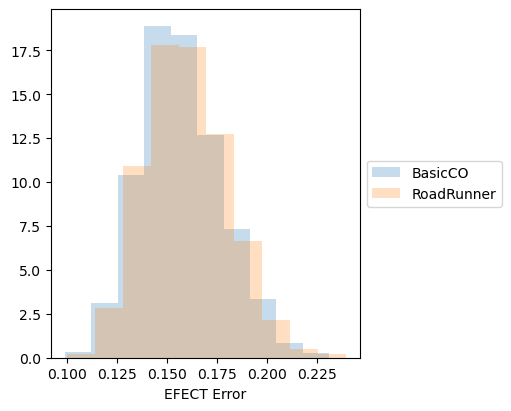

In [10]:
fig, ax = plt.subplots(1, 1, layout='compressed', figsize=(5.0, 4.0))

for sim_name, res in zip(sim_labels, err_samples):
    ax.hist(res, density=True, label=sim_name, alpha=0.25)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
_ = ax.set_xlabel('EFECT Error')

# Generate EFECT Reports

In [11]:
eval_num = 100
efect_reports: List[libssr.EFECTReport] = []

size_export = int(sample_size // 2)

for i, res in enumerate(results):

    ecf_evals = np.ndarray((num_steps, len(model_names), eval_num, 2), dtype=float)
    ecf_tval = np.ndarray((num_steps, len(model_names)), dtype=float)
    for j, name in enumerate(model_names):
        res_name = res[name]
        for k in range(num_steps):
            sample_i = res_name[:size_export, k]
            ecf_tval[k, j] = libssr.eval_final(sample_i)
            ecf_evals[k, j, :, :] = libssr.ecf(sample_i, libssr.get_eval_info_times(eval_num, ecf_tval[k, j]))

    sdata = libssr.EFECTReport.create(
        variable_names=model_names,
        simulation_times=results_times,
        sample_size=size_export,
        ecf_evals=ecf_evals,
        ecf_tval=ecf_tval,
        ecf_nval=eval_num,
        error_metric_mean=np.mean(err_samples[i]),
        error_metric_stdev=np.std(err_samples[i]),
        sig_figs=16
    )
    efect_reports.append(sdata)

# Compare Samples

In [12]:
sig_level = 0.05

efect_errors = {}
pvals = {}

for i in range(len(err_samples[:-1])):
    efect_errors[sim_labels[i]] = {}
    pvals[sim_labels[i]] = {}

    sdata_i = efect_reports[i]
    for j in range(i+1, len(err_samples)):
        sdata_j = efect_reports[j]
        halfdata_j = {n: v[:sample_size // 2, :] for n, v in results[j].items()}
        err = 0.0
        for ni, n in enumerate(sdata_i.variable_names):
            for k in range(sdata_i.simulation_times.shape[0]):
                eval_t = libssr.get_eval_info_times(sdata_i.ecf_nval, sdata_i.ecf_tval[k, ni])
                ecf_i = sdata_i.ecf_evals[k, ni, :, :]
                ecf_j = libssr.ecf(halfdata_j[n][:, k], eval_t)
                err = max(err, libssr.ecf_compare(ecf_i, ecf_j))
        pval = libssr.pval(err_samples[i], err)

        efect_errors[sim_labels[i]][sim_labels[j]] = err
        pvals[sim_labels[i]][sim_labels[j]] = pval

        rejected = pval <= sig_level
        print(f'{sim_labels[i]}/{sim_labels[j]}:', 'Not Reproduced' if rejected else 'Reproduced', f'({err}, {pval})')

BasicCO/RoadRunner: Reproduced (0.17075936526778046, 1.0)
